In [2]:
import numpy as np
# Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
import mnist_loader

import matplotlib.pyplot as plt
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

training_data = list(training_data)[:10]
unlabeled_data = np.array([data[0] for data in training_data])
data = unlabeled_data.T.reshape(784,-1) # each example stored in a column










In [32]:
def sigmoid(x):
	return 1/(1+np.exp(-x))

def sp(sigma):
	return sigma*(1-sigma)


def feedforward(x, w, b):  # Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
    # x should have examples in columns!
    a_hidden = sigmoid(np.dot(w,x)+b[0])
    a_out = sigmoid(np.dot(w.transpose(),a_hidden)+b[1])
    return [a_hidden, a_out] # Examples are still stored in columns in the hidden layer
# B's will work, I just need to be careful when I recreate images.

def backprop(x, w, b):
    a_hidden, a_out = feedforward(x,w,b)
    d_out = (a_out-x)*sp(a_out) # Using quad-cost for now
    d_hidden = np.dot(w,d_out)*sp(a_hidden)

    #dW_jk = a_k_l-1 * d_j
    dC_dw_T = np.dot(d_out, a_hidden.transpose())
    dC_dw_input = np.dot(d_hidden, x.transpose())

    dC_dw = dC_dw_input+dC_dw_T.transpose()
    dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
    return dC_dw, dC_db


def backpropsparse(x,w,b,rho,beta):
    a_hidden, a_out = feedforward(x,w,b)
    rho_hat = np.sum(a_hidden, axis = 1).reshape(len(a_hidden),1) # I'm pretty sure the dimension
    KL_deriv = (beta*(-(rho/rho_hat)+((1-rho)/(1-rho_hat)))).reshape(len(a_hidden),1)
    d_out = (a_out-x)*sp(a_out)
    d_hidden = (np.dot(w,d_out)+KL_deriv)*sp(a_hidden)
    
    #dW_jk = a_k_l-1 * d_j
    dC_dw_T = np.dot(d_out, a_hidden.transpose())
    dC_dw_input = np.dot(d_hidden, x.transpose())

    dC_dw = dC_dw_input+dC_dw_T.transpose()
    dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
    return dC_dw, dC_db, rho_hat

def update_net(x,w,b,rho = 0, beta = 0, sparse = 0):
    if sparse:
        dC_dw, dC_db, rho_hat = backpropsparse(x, w, b,rho,beta)
    else:
        dC_dw, dC_db = backprop(x, w, b)
        rho_hat = [0,0]
    # Using gradient descent
    w = w - dC_dw
    b[0] = b[0] - dC_db[0]
    b[1] = b[1] - dC_db[1]
    return w,b,rho_hat

def eval_err(data,w,b):
	prediction = feedforward(data,w,b)
	error = sum(sum((prediction[1] - data)**2))
	return error

# use this guy if not including sparcity term
def Grad_descent(data,w,b,iterations,sparse):
    for i in range(iterations):
        w,b = update_net(data,w,b)
        
        if i%499 == 0:
            print(eval_err(data,w,b))
    return w,b
        
def Grad_descent_sparse(data,w,b,iterations,sparse,rho = 0,beta = 0):
    rho_hat_avg = []
    for i in range(iterations):
        w,b,rho_hat = update_net(data,w,b,rho,beta,sparse)
        rho_hat_avg.append(sum(rho_hat)/len(rho_hat))
        if i%50 == 0:
            print(eval_err(data,w,b))    
    
    return w,b,rho_hat_avg


In [24]:
tester = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(tester)
print(np.sum(tester, axis = 0).reshape(3,1).shape)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
(3, 1)


In [78]:
hidden_size = 15
sizes = [784,hidden_size,784]
b= [np.zeros((hidden_size,1)), np.zeros((784,1))]
w = np.random.randn(sizes[1],sizes[0])/np.sqrt(sizes[0])
rho = 0.05
beta = 0
# for i in range(1000):
#     w,b = update_net(data,w,b,rho,beta)

#     if i%499 == 0:
#         print(eval_err(data,w,b))
w,b,rho_hat_avg = Grad_descent_sparse(data,w,b,400,sparse = 0,rho = 0.1 ,beta = 1)
# This means it's not 
# w,b = Grad_descent(data,w,b,200,0)





602.575326271
246.866109948
131.230949531
114.414746492
106.920530316
102.577938823
99.8527279009
97.9832579938


In [45]:
%matplotlib inline

(784,)
(784, 1)


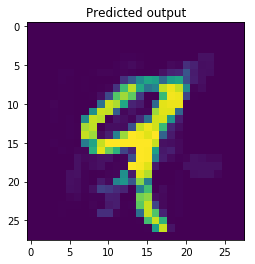

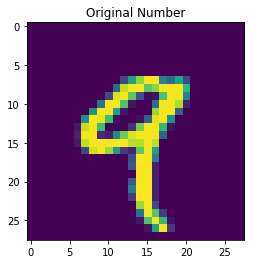

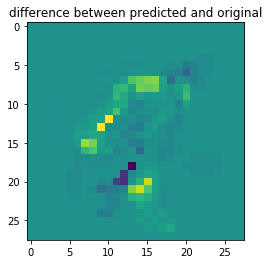

In [79]:
import matplotlib.pyplot as plt

digit = 4
output = feedforward(data.T[digit].reshape(784,1),w,b) # Have to transpose becasue egs are in columns.
print(data.T[0].shape)
output = np.array(output[1])
print(output.shape)

plt.imshow(np.array(output).reshape(28,28))
plt.title('Predicted output')
plt.show()

plt.figure()
plt.imshow(np.array(data.T[digit].reshape(28,28)))
plt.title('Original Number')
plt.show()

plt.figure()
plt.imshow(np.array(data.T[digit].reshape(28,28))-np.array(output).reshape(28,28))
plt.title('difference between predicted and original')
plt.show()

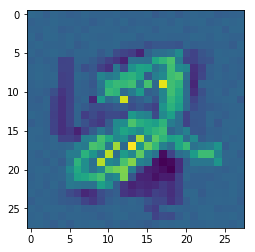

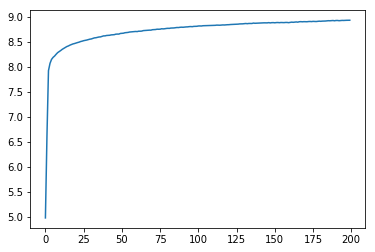

In [75]:
plt.plot(range(len(rho_hat_avg)),rho_hat_avg)
plt.show()

# This at least shows the sparcity constraint is working!

(784,)
(784,)


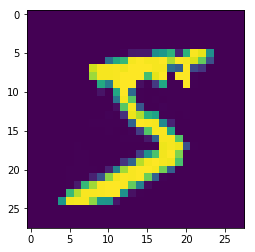

In [44]:
import matplotlib.pyplot as plt
output = feedforward(data.T[0],w,b) # Have to transpose becasue egs are in columns.
print(data.T[0].shape)
output = np.array(output[1])
print(output.shape)
plt.imshow(np.array(output).reshape(28,28))
plt.show()

In [41]:
print(data.T[0].shape)
output = feedforward(data.T[0],w,b)
print(output[0].shape)

(784,)
(500,)


In [55]:
np.dot(w,data.T[0])

array([-237.53420246,   76.71126651,  302.58931366,   39.83378334,
        181.54851334])

In [81]:
print((np.dot(w,data.T[0].reshape(784,1))+b[0]))

[[ -58.48785446]
 [ -35.05604177]
 [ -39.52049315]
 [   4.07225429]
 [-161.84055564]
 [ 265.70459322]
 [-124.67388718]
 [ 173.80361307]
 [-146.15797637]
 [ -29.42991111]
 [ -30.76326077]
 [-111.2819129 ]
 [ -38.95729487]
 [ -40.45521768]
 [ 334.99732292]]


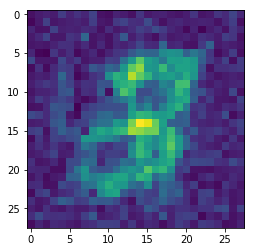

In [81]:
feature = w[4].reshape(28,28)
plt.imshow(feature)
plt.show()

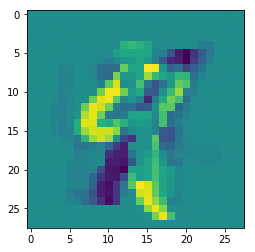

In [85]:
feature = w[4].reshape(28,28)
plt.imshow(feature)
plt.show()

IDEAS STILL TO DO
Implement momentum
Weight Decay regularization (L2)?
Actually, the obvious one is that if I'm going to use sparsity, I should have more neurons.
Also, I seem to be getting division by 0 error. 

Otherwise, I'm not sure why it's not working...

Perhaps I'm using too big an image. They used 64x64 patches, and many of them, to do theirs.

In [22]:
dim_test = feedforward(data,w,b)
print(len(dim_test[0][0]))

10


In [31]:
for row in w:
    

TypeError: 'int' object is not iterable

AttributeError: 'AxesSubplot' object has no attribute 'flat'

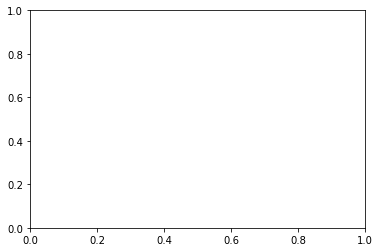

In [62]:
figure, axes = plt.subplots(nrows = 1, ncols = hidden_size)
index = 0                                    
for axis in axes.flat:

    """ Add row of weights as an image to the plot """

    image = axis.imshow(w[index, :].reshape(28,28), interpolation = 'nearest')
    axis.set_frame_on(False)
    axis.set_axis_off()
    index += 1

""" Show the obtained plot """  

plt.show()

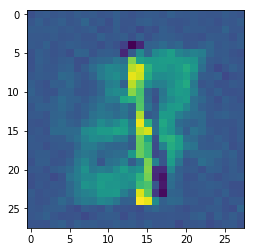

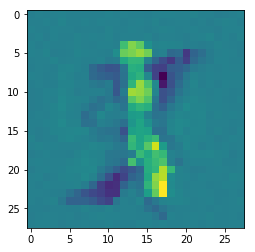

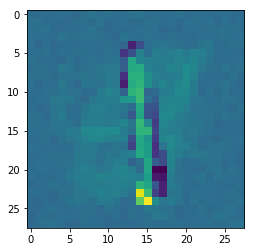

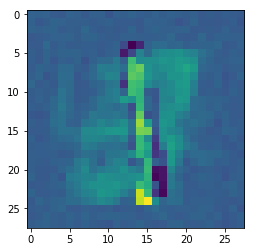

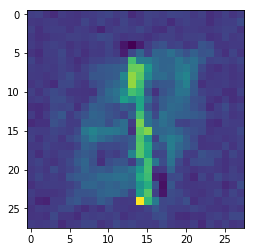

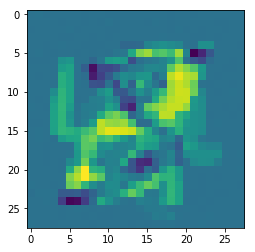

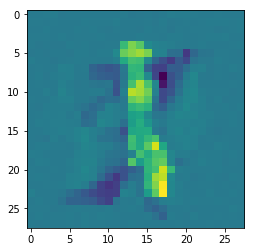

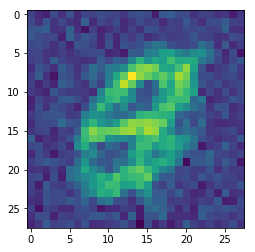

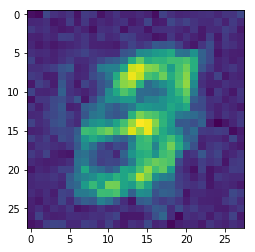

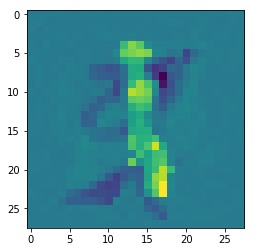

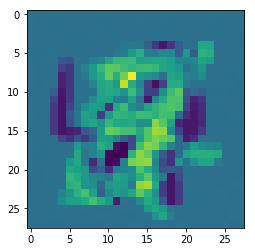

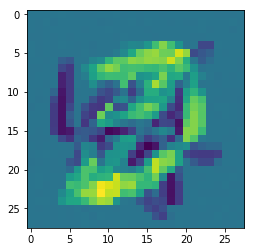

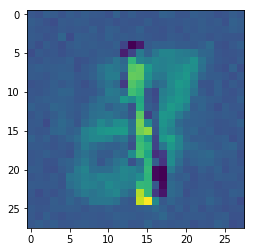

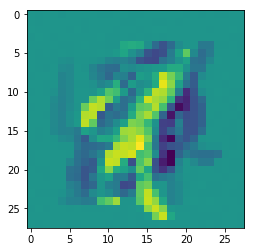

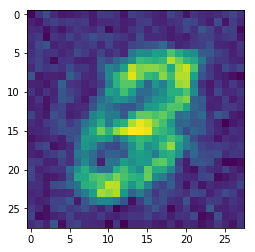

In [82]:
for row in w:
    plt.figure()
    plt.imshow(row.reshape(28,28), interpolation = 'nearest')
    plt.show()
